# Reward Training vs. Reward Competiton - Peak Detection

In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from Reward_Training.rt_extension import Reward_Training
from Reward_Competition.rc_extension import Reward_Competition
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks


In [2]:
# Reward Competition files
experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Competition\combined_cohorts"

csv_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Competition\combined_cohorts\manual_scoring_combined.xlsx"

# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Competition\Test"

In [3]:
# Reward Training files
# NAc
rt_NAc_experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Training\Combined\Day10\NAc"
nac_color = '#15616F'

# mPFC
rt_mPFC_experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Training\Combined\Day10\mPFC"
mPFC_color = '#FFAF00'


### Reward Competition Pre-processing

In [4]:
# rc_exp = Reward_Competition(experiment_folder_path=experiment_path, behavior_folder_path=None)
# rc_exp.rtc_processing()
# rc_exp.read_and_merge_manual_scoring(csv_path)
# rc_exp.remove_tangles()   # Remove sound cues and winner array indexes where there are tangles
# rc_exp.remove_specified_subjects()   # Remove specified subjects from the analysis
# rc_exp.extract_da_columns()   # Grab only essential columns for analysis
# rc_exp.find_first_port_entry_after_sound_cue()
# rc_exp.compute_EI_DA()
# rc_exp.compute_rtc_da_metrics().head()
# rc_exp.split_by_winner()

### Reward Training Pre-processing

In [5]:
rt_NAc_exp = Reward_Training(experiment_folder_path=rt_NAc_experiment_path, behavior_folder_path=None)
rt_mPFC_exp = Reward_Training(experiment_folder_path=rt_mPFC_experiment_path, behavior_folder_path=None)

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Training\Combined\Day10\NAc\n5-240911-062153\Notes.txt
read from t=0s to t=1769.26s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Training\Combined\Day10\NAc\n7-240911-111928\Notes.txt
read from t=0s to t=1688.06s
read from t=0s to t=3853.09s
read from t=0s to t=3853.09s
read from t=0s to t=3851.18s
read from t=0s to t=3851.18s
read from t=0s to t=3845.28s
read from t=0s to t=3845.28s
read from t=0s to t=3845.28s
read from t=0s to t=3845.28s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Training\Combined\Day10\mPFC\p1-240607-065311\Notes.txt
read from t=0s to t=1684.75s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Training\Combined\Day10\mPFC\p2-240607-092425\Notes.txt
read from t=0s to t=1761.77s
Fo

In [ ]:
def run_rtc_pipeline(exp, experiment_path):
    exp.rtc_processing()
    exp.create_base_df(experiment_path)
    exp.remove_specified_subjects()
    exp.extract_da_columns()
    exp.find_first_port_entry_after_sound_cue()
    # exp.compute_closest_port_offset(
    #     PE_column='first_PE_after_sound_cue',
    #     offset_column='filtered_port_entry_offset'
    # )Reward_Training-Competition/RT_vs_RC/rt_vs_rc_Peak_Detection.ipynb
    exp.compute_EI_DA()
    exp.compute_rtc_da_metrics()

run_rtc_pipeline(rt_NAc_exp, rt_NAc_experiment_path)
run_rtc_pipeline(rt_mPFC_exp, rt_mPFC_experiment_path)

Processing trial n5-240911-062153...
Processing trial n7-240911-111928...
Processing trial nn1-250202-133348...
Processing trial nn2-250202-133348...
Processing trial nn3-250202-122021...
Processing trial nn4-250202-122021...
Processing trial nn5-250202-082015...
Processing trial nn6-250202-082015...
Processing trial nn7-250202-070333...
Processing trial nn8-250202-070333...


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

## RT Peak Detection

In [ ]:
# rt_NAc_exp.compute_spontaneous_events(threshold_factor=3.5, min_distance_s=0.5, min_width_s=0.3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_trace_segment_with_peaks(
    da_df,
    time_window: tuple = (0, 60),
    threshold_factor: float = 3.0,
    min_distance_s: float = 1.0,
    min_width_s:    float = 0.5,
    region: str = None,          # 'NAc', 'mPFC' or None for all
    figsize_per_trace: tuple = (12, 2),
    mark_color: str = 'red',
    tone_line_color: str = 'gray',
    tone_line_style: str = '--'
):
    """
    Plot a time‐window segment of each session's z‐score trace, mark spontaneous peaks,
    and draw dashed vertical lines at each tone onset within that window.
    """
    t0, t1 = time_window

    # 1) optional region filter
    if region is not None:
        prefix = 'n' if region=='NAc' else 'p'
        df_plot = da_df[da_df['subject_name'].str.startswith(prefix)]
    else:
        df_plot = da_df

    if df_plot.empty:
        print("No sessions to plot.")
        return

    # 2) make one row per session
    n = len(df_plot)
    fig, axes = plt.subplots(n, 1,
                             figsize=(figsize_per_trace[0],
                                      figsize_per_trace[1]*n),
                             sharex=False)
    if n == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, df_plot.iterrows()):
        # --- slice the main trace ---
        ts_full = np.asarray(row['trial'].timestamps, dtype=float)
        zs_full = np.asarray(row['trial'].zscore,     dtype=float)
        mask    = (ts_full >= t0) & (ts_full <= t1)
        ts, zs  = ts_full[mask], zs_full[mask]

        # --- detect peaks in that slice ---
        peak_times, peak_amps, _ = detect_spontaneous_events(
            ts, zs,
            threshold_factor=threshold_factor,
            min_distance_s=min_distance_s,
            min_width_s=min_width_s
        )

        # --- plot the trace & peaks ---
        ax.plot(ts, zs, color='black', lw=1)
        ax.scatter(peak_times, peak_amps,
                   color=mark_color, s=40,
                   label='spontaneous peaks', zorder=5)

        # --- draw tone‐onset lines ---
        # pick your cue column here:
        cues = row.get('filtered_sound_cues', []) or []
        for cue in cues:
            if t0 <= cue <= t1:
                ax.axvline(cue, color=tone_line_color,
                           linestyle=tone_line_style, lw=1)

        ax.set_title(f"{row['file name']} ({row['subject_name']})", fontsize=10)
        ax.set_xlim(t0, t1)
        ax.set_ylabel("z ΔF/F", fontsize=9)
        ax.legend(loc='upper right', fontsize=8)

    axes[-1].set_xlabel("Time (s)", fontsize=10)
    plt.tight_layout()
    plt.show()


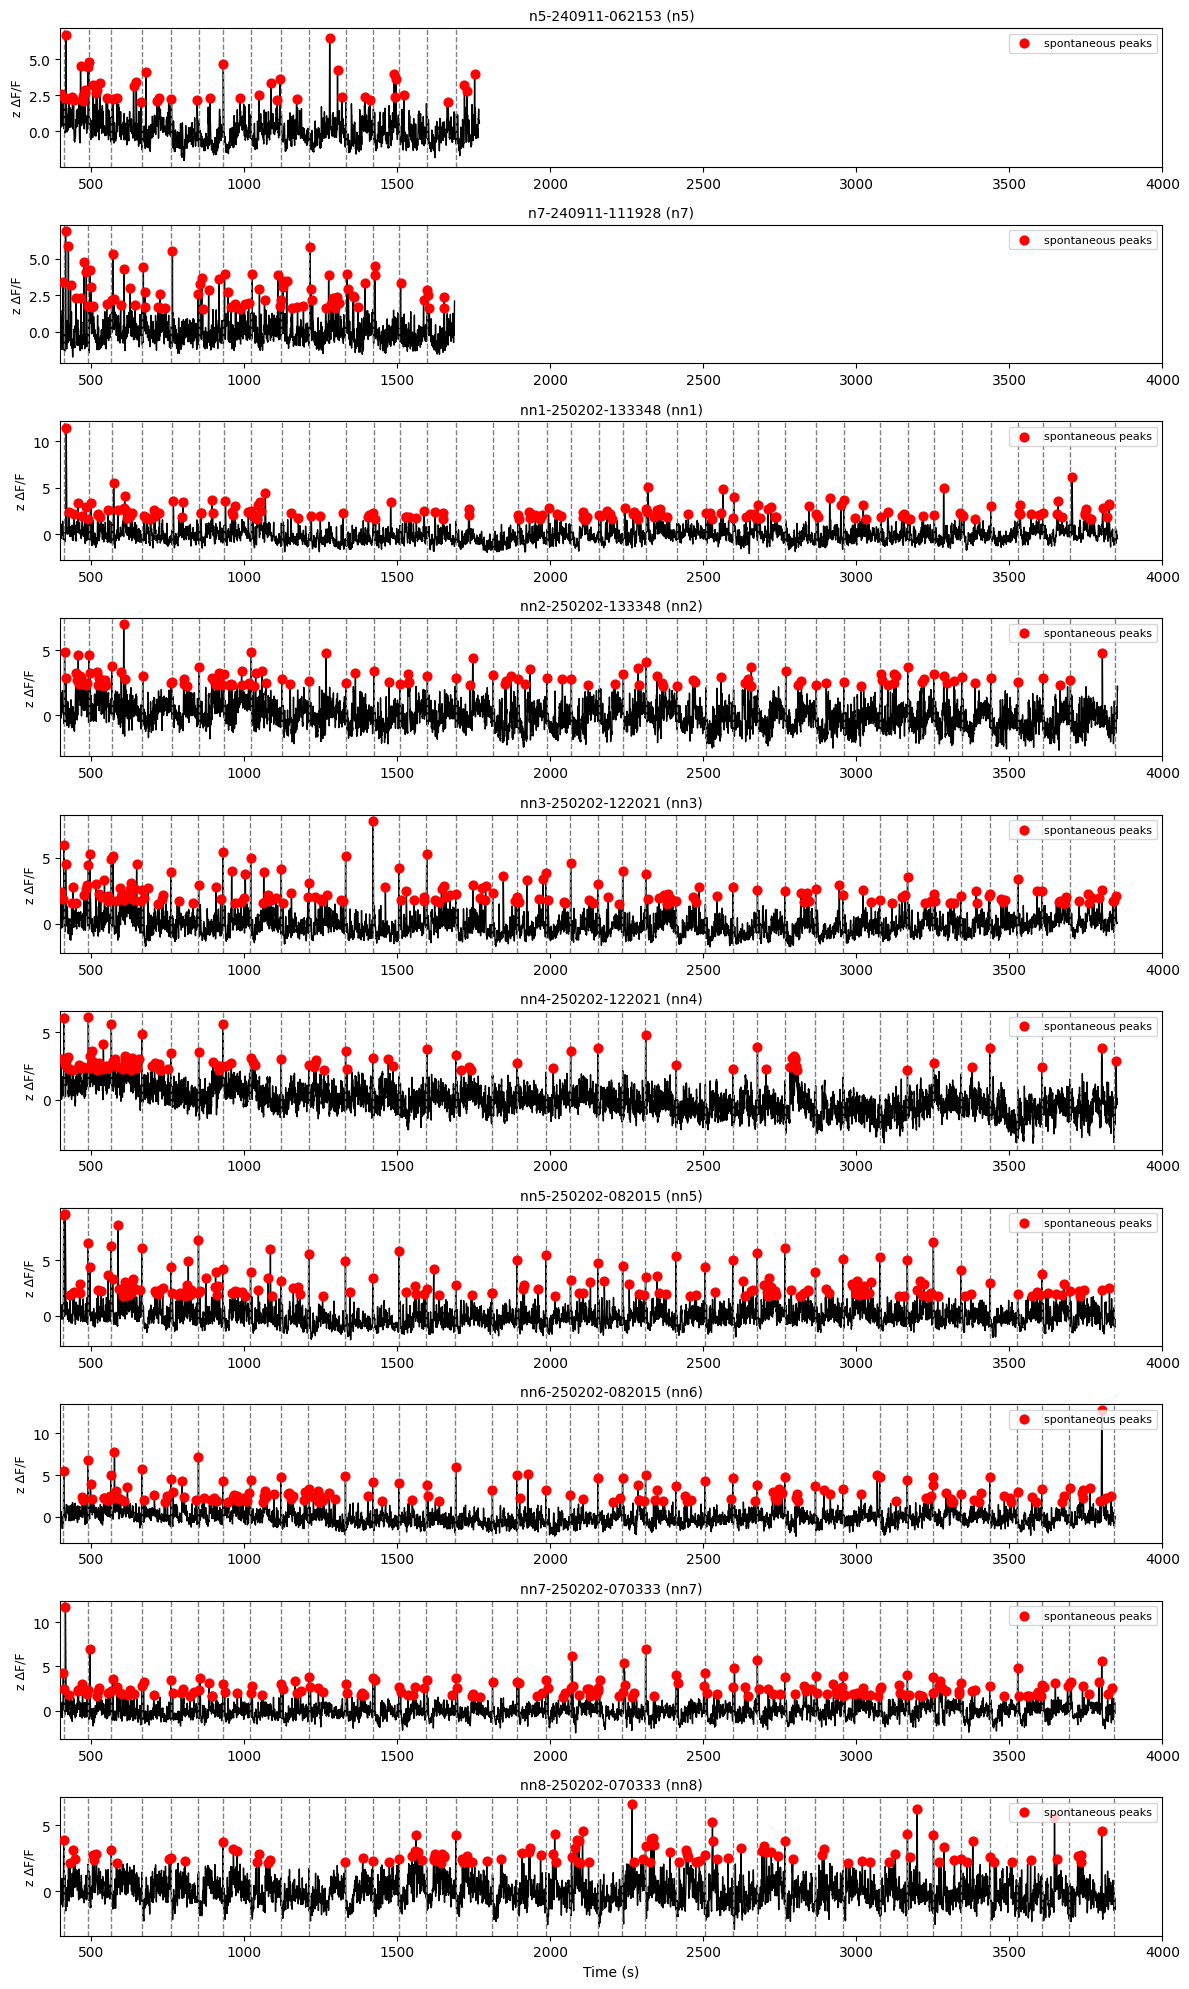

In [ ]:
plot_trace_segment_with_peaks(
    rt_NAc_exp.da_df,
    time_window=(400,4000),
    threshold_factor=3.5,
    min_distance_s=0.5,
    min_width_s=0.3,
    region='NAc'
)

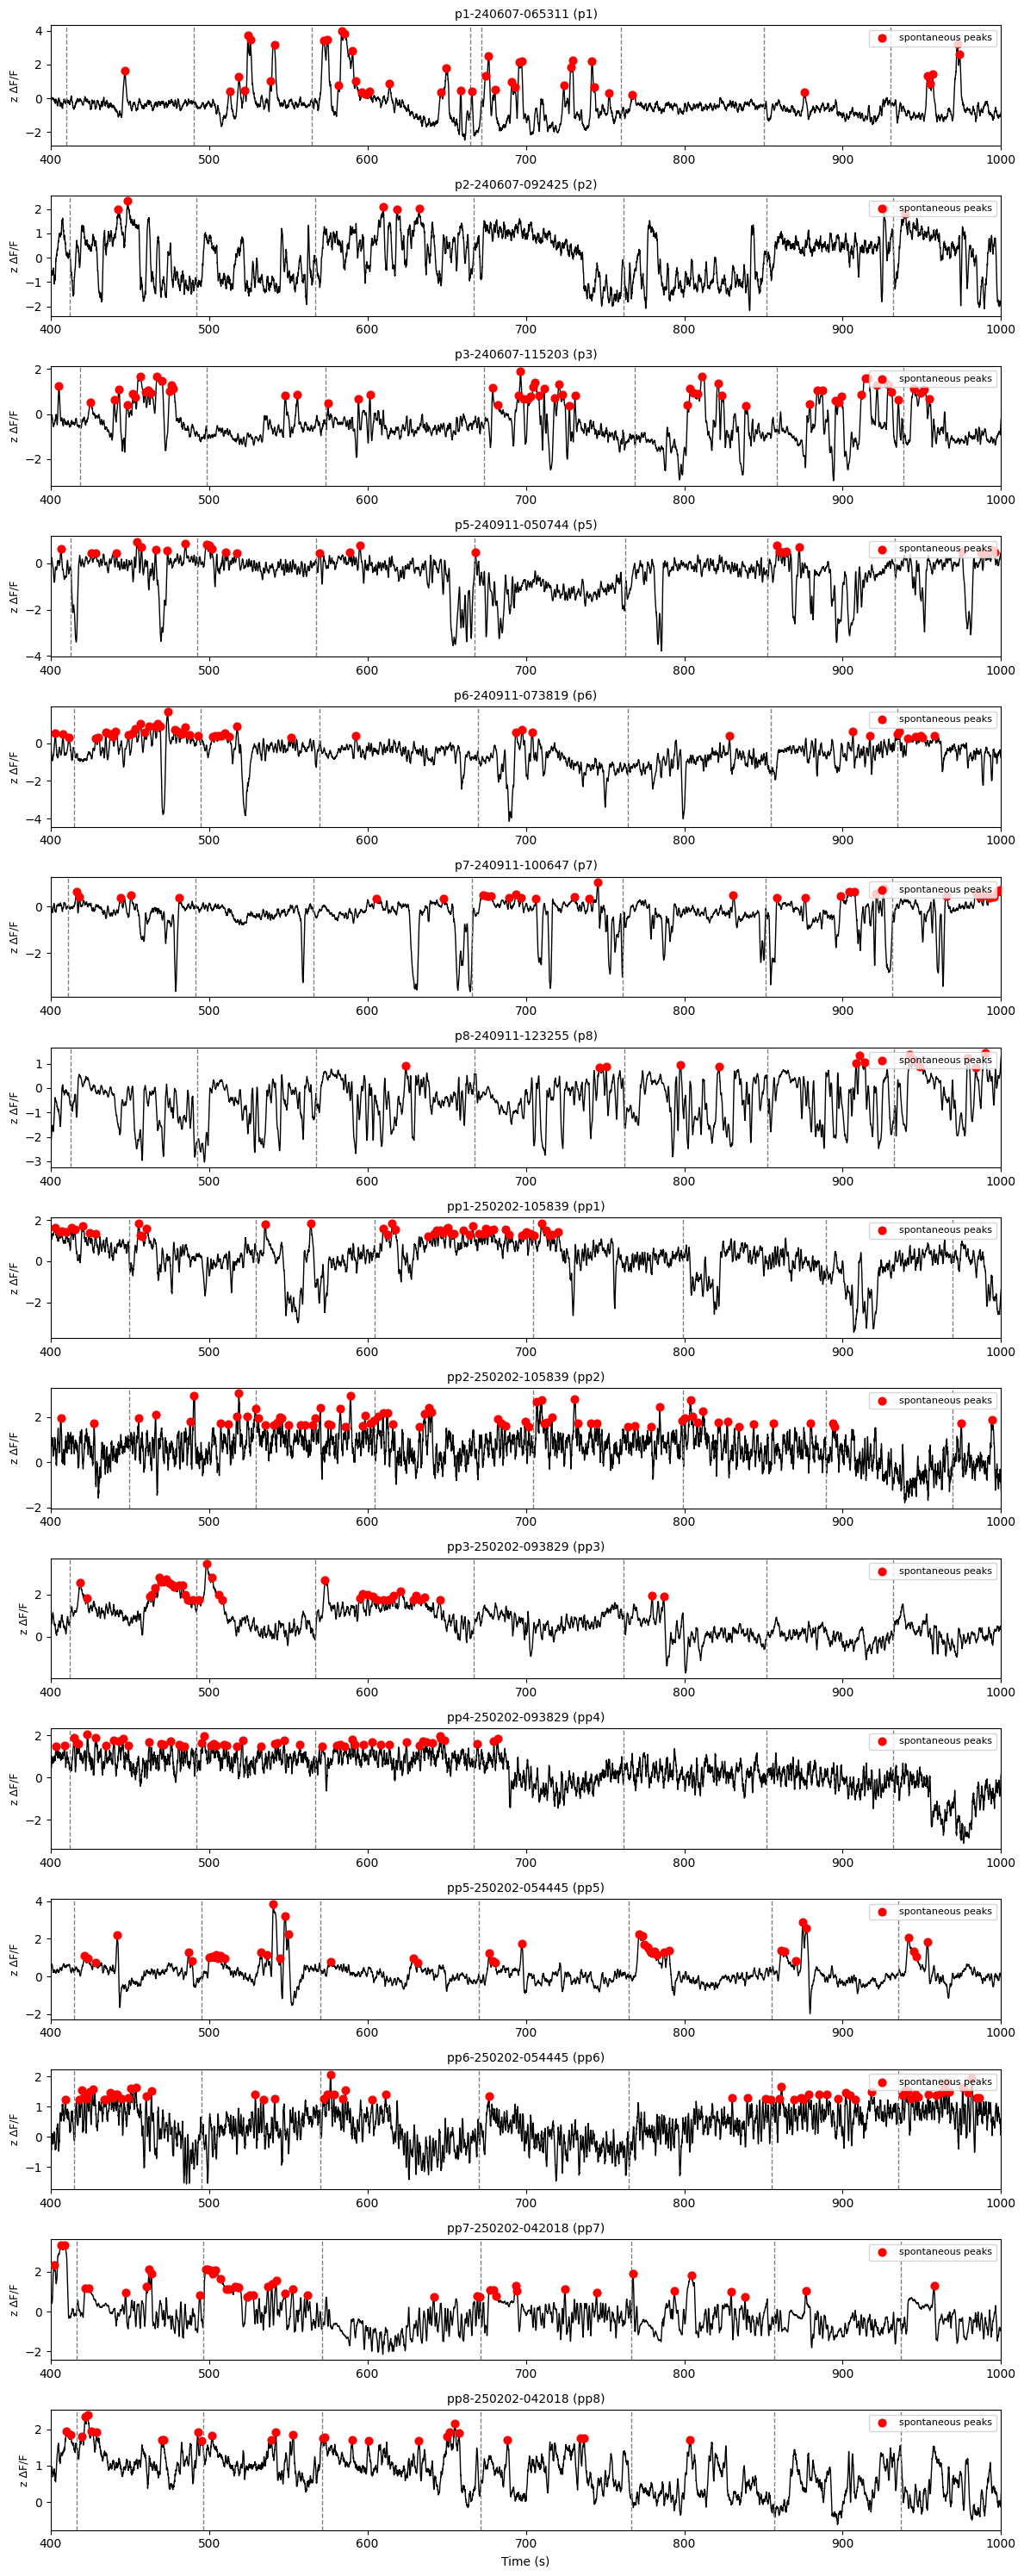

In [ ]:
plot_trace_segment_with_peaks(
    rt_mPFC_exp.da_df,
    time_window=(400,1000),
    threshold_factor=2,
    min_distance_s=0.5,
    min_width_s=0.3,
    region='mPFC'
)
